### Task 4.1 Data Visualization and Preprocessing

In [2]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

#### 4.1.1 Data Visualization (Distribution of various labels)

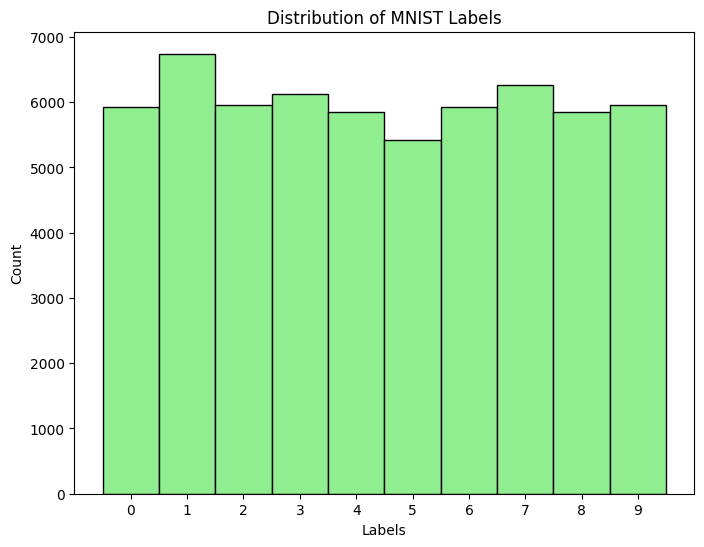

In [80]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Get labels
labels = dataset.targets.numpy()

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.hist(labels, bins=np.arange(11) - 0.5, color='lightgreen', edgecolor='black')
plt.xticks(np.arange(10))
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of MNIST Labels')
plt.show()

#### 4.1.2 Visualisation of the data samples

##### dispalying 5 samples from each class

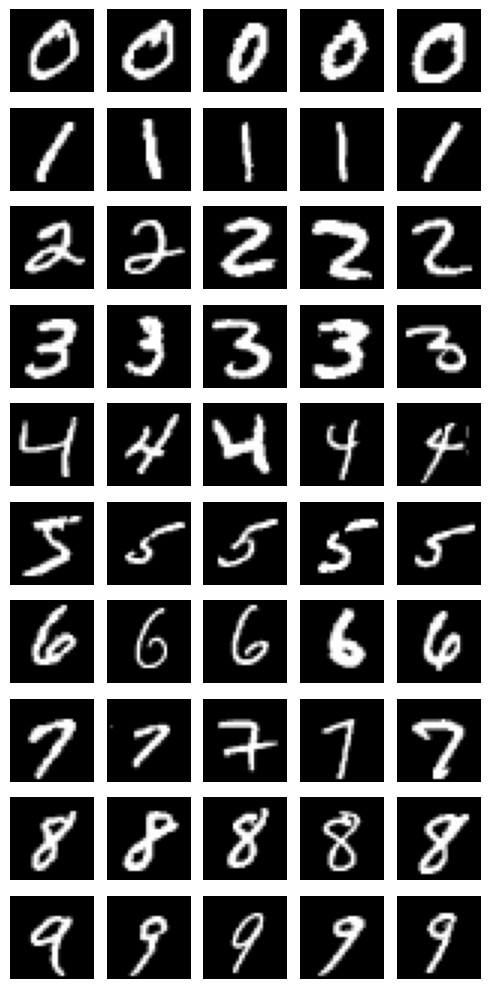

In [5]:
# Function to visualize samples from each class
def visualize_samples(dataset, num_samples=5):
  classes = list(set(dataset.targets.numpy()))
  fig, axes = plt.subplots(len(classes), num_samples, figsize=(num_samples, len(classes)))

  for i, class_idx in enumerate(classes):
    class_samples = dataset.data[dataset.targets == class_idx][:num_samples]
    for j in range(num_samples):
      axes[i, j].imshow(class_samples[j], cmap='gray')
      axes[i, j].axis('off')

  plt.tight_layout()
  plt.show()

# Visualize samples
visualize_samples(dataset)

#### 4.1.3 Class Imbalance Check

In [6]:
class_counts = np.bincount(labels)
class_imbalance = class_counts / len(labels)
print("Class Imbalance:")
for i, count in enumerate(class_counts):
  print(f"Class {i}: {count} samples, {class_imbalance[i]*100:.2f}%")

Class Imbalance:
Class 0: 5923 samples, 9.87%
Class 1: 6742 samples, 11.24%
Class 2: 5958 samples, 9.93%
Class 3: 6131 samples, 10.22%
Class 4: 5842 samples, 9.74%
Class 5: 5421 samples, 9.04%
Class 6: 5918 samples, 9.86%
Class 7: 6265 samples, 10.44%
Class 8: 5851 samples, 9.75%
Class 9: 5949 samples, 9.92%


#### 4.1.4 Splitting the data into train, val and test

In [81]:
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = (total_size - train_size) // 2
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Train dataset size: {len(train_dataset)}")
print(train_dataset[0][0].shape)

Train dataset size: 42000
torch.Size([1, 28, 28])


#### 4.1.5 Function to visualise feature maps

In [8]:
def visualize_feature_maps(model, image, layer_num):
  model.eval()
  with torch.no_grad():
    # Forward pass the image through the model until the specified layer
    activations = None
    for idx, layer in enumerate(model.layers):
      image = layer(image)
      if idx == layer_num:
        activations = image
        break

  # Visualize the feature maps
  num_feature_maps = activations.size(1)
  fig, axes = plt.subplots(1, num_feature_maps, figsize=(20, 2))
  for i in range(num_feature_maps):
    axes[i].imshow(activations[0, i].cpu(), cmap='viridis')
    axes[i].axis('off')
  plt.show()
  
  return activations

### Task 4.2 CNN Model Implementation

In [208]:
class Reshape(nn.Module):
  def __init__(self, shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.view(self.shape)

class CNN(nn.Module):
  def __init__(
    self,
    kernel_size=3,
    stride=1,
    padding=1,
    dropout=0.2,
    learning_rate=0.001,
    batch_size=64,
    num_epochs=10
  ):
    super(CNN, self).__init__()
    
    self.conv1 = nn.Conv2d(
      in_channels=1, 
      out_channels=16, 
      kernel_size=kernel_size, 
      stride=stride,
      padding=padding
    )
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    self.conv2 = nn.Conv2d(
      in_channels=16, 
      out_channels=32,
      kernel_size=kernel_size,
      stride=stride,
      padding=padding
    )
    self.dim = 28
    # after first layer
    self.dim = ((self.dim - kernel_size + 2*padding) // stride) + 1
    # after first pooling
    self.dim //= 2
    # after second layer
    self.dim = ((self.dim - kernel_size + 2*padding) // stride) + 1
    # after second pooling
    self.dim //= 2
    self.adjust_shape = Reshape((-1, 32 * self.dim * self.dim))
    
    self.dropout = nn.Dropout(p=dropout)
    self.fc = nn.Linear(32 * self.dim * self.dim, 10)
    self.softmax = nn.Softmax(dim=1)
    
    self.layers = [                              # Image size 28 * 28
      self.conv1,         # 16 * 28 * 28         # kernel_size=3, stride=1, padding=1        # 16 * ((28 - kernel_size + 2*padding) / stride + 1) * 28
      self.relu,          # 16 * 28 * 28
      self.pool,          # 16 * 14 * 14
      self.conv2,         # 32 * 14 * 14
      self.relu,          # 32 * 14 * 14
      self.pool,          # 32 * 7 * 7
      self.dropout,       # 32 * 7 * 7
      self.adjust_shape,  # 1568
      self.fc,            # 10
      self.softmax        # 10
    ]
    
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
    self.num_epochs = num_epochs
    self.batch_size = batch_size

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)
    
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    
    x = self.dropout(x)
    x = self.adjust_shape(x)
    x = self.fc(x)
    x = self.softmax(x)
    return x
  
  def train_model(self, train_dataset, val_dataset):
    train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True)
    
    train_loss, val_loss, accuracy, val_accuracy = 0,0,0,0
    
    for epoch in range(self.num_epochs):
      self.train()
      train_loss = 0.0
      correct = 0
      total = 0
      
      val_loss = 0.0
      val_correct = 0
      val_total = 0
      
      for inputs, labels in train_loader:
        self.optimizer.zero_grad()
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        loss.backward(retain_graph=True)
        self.optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        # print("Predicted shape:", predicted.shape)
        # print("Labels shape:", labels.shape)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

      self.eval()
      for inputs, labels in val_loader:
        self.optimizer.zero_grad()
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        loss.backward(retain_graph=True)
        self.optimizer.step()

        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

      val_accuracy = val_correct / val_total
      accuracy = correct / total

      print(
        f'Epoch {epoch+1}/{self.num_epochs}, '
        f'Loss(Train): {train_loss:.4f}, '
        f'Accuracy(Train): {accuracy:.2f}, '
        f'Loss(Val): {val_loss:.4f}, '
        f'Accuracy(Val): {val_accuracy:.2f}'
      )
    return train_loss, val_loss, accuracy, val_accuracy
  
  def predict(self, pred_dataset):
    pred_loader = DataLoader(pred_dataset, batch_size=self.batch_size, shuffle=False)
    self.eval()
    predictions = []
    labels_true = []
    for inputs, labels in pred_loader:
      outputs = self(inputs)
      _, predicted = torch.max(outputs.data, 1)
      predictions.extend(predicted.tolist())
      labels_true.extend(labels.numpy())
    return predictions, labels_true


In [174]:
model = CNN(
  num_epochs=5
)
model.train_model(train_dataset, val_dataset)

Epoch 1/5, Loss(Train): 1072.2472, Accuracy(Train): 0.84, Loss(Val): 212.1877, Accuracy(Val): 0.96
Epoch 2/5, Loss(Train): 988.0192, Accuracy(Train): 0.96, Loss(Val): 209.8779, Accuracy(Val): 0.97
Epoch 3/5, Loss(Train): 981.0790, Accuracy(Train): 0.97, Loss(Val): 209.3390, Accuracy(Val): 0.98
Epoch 4/5, Loss(Train): 978.1566, Accuracy(Train): 0.97, Loss(Val): 208.8419, Accuracy(Val): 0.98
Epoch 5/5, Loss(Train): 976.3421, Accuracy(Train): 0.98, Loss(Val): 208.3355, Accuracy(Val): 0.98


(976.3420816659927, 208.3355314731598, 0.9759761904761904, 0.9844444444444445)

Original Image


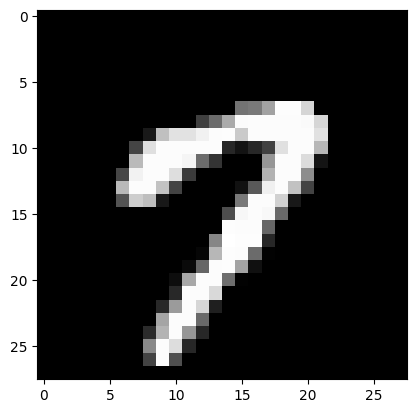

Layer 0: Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


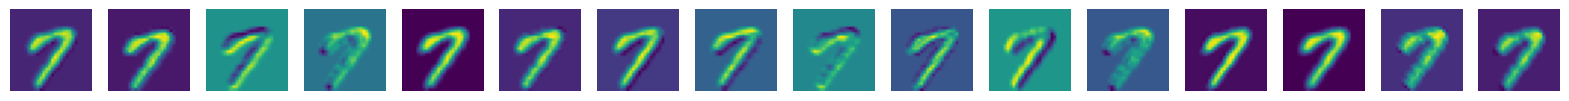

Layer 1: ReLU()


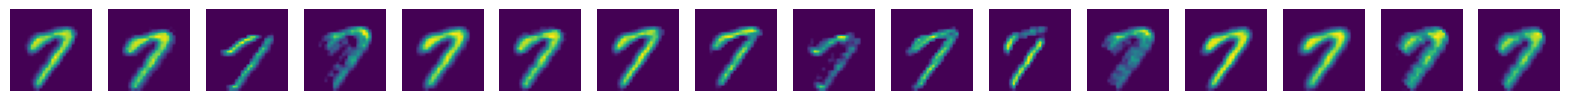

Layer 2: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


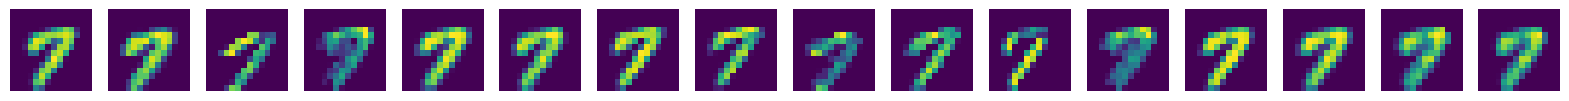

Layer 3: Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


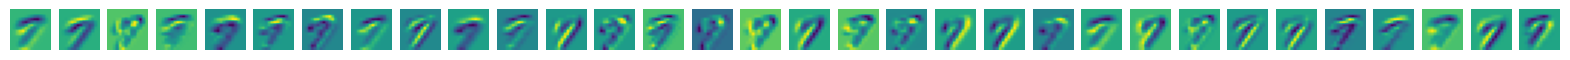

Layer 4: ReLU()


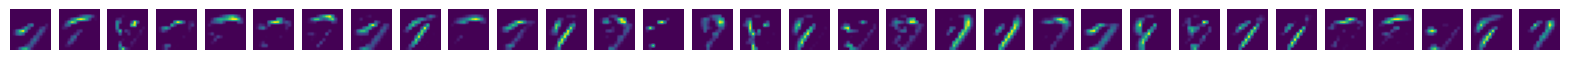

Layer 5: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


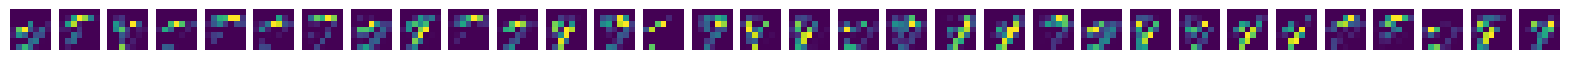

Layer 6: Dropout(p=0.2, inplace=False)


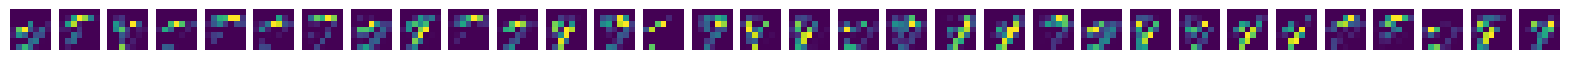

Layer 7: Reshape()
torch.Size([1, 1568])
Layer 8: Linear(in_features=1568, out_features=10, bias=True)
torch.Size([1, 10])
Layer 9: Softmax(dim=1)
torch.Size([1, 10])
Predicted Label: 7


In [11]:
digit = np.random.randint(0,10)
image = dataset.data[dataset.targets == digit][0].float().unsqueeze(0).unsqueeze(0)
print('Original Image')
plt.imshow(image[0, 0], cmap='gray')
plt.show()
act = None
for i in range(len(model.layers[:7])):
  print(f'Layer {i}: {model.layers[i]}')
  act = visualize_feature_maps(model, image, i)
for i in range(len(model.layers[7:])):
  print(f'Layer {i+7}: {model.layers[i+7]}')
  act = model.layers[i+7](act)
  print(act.shape)

print('Predicted Label:', torch.argmax(act).item())

#### Confusion Matrix

In [12]:
y_pred, y_true = model.predict(test_dataset)
conf_mat = pd.DataFrame(confusion_matrix(y_true, y_pred))
conf_mat.head(10)

,0,1,2,3,4,5,6,7,8,9
0,831,0,2,0,0,0,6,0,4,1
1,0,967,9,2,0,0,0,3,5,0
2,3,1,915,0,2,0,0,3,3,1
3,0,0,9,890,0,11,0,7,4,2
4,1,2,3,0,853,0,2,1,0,4
5,0,1,0,3,0,809,1,0,3,0
6,3,2,0,0,2,6,910,0,4,0
7,0,1,5,1,2,0,0,915,3,3
8,0,2,3,3,3,6,1,3,856,3
9,4,1,0,4,3,9,0,7,10,861


In [13]:
class_rep = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).transpose()
class_rep.head(13)

,precision,recall,f1-score,support
0,0.986936,0.984597,0.985765,844.000000
1,0.989765,0.980730,0.985227,986.000000
2,0.967230,0.985991,0.976521,928.000000
3,0.985604,0.964247,0.974808,923.000000
4,0.986127,0.984988,0.985557,866.000000
5,0.961950,0.990208,0.975875,817.000000
6,0.989130,0.981661,0.985382,927.000000
7,0.974441,0.983871,0.979133,930.000000
8,0.959641,0.972727,0.966140,880.000000
9,0.984000,0.957731,0.970688,899.000000


### Task 4.3 Hyperparameter Tuning

In [14]:
import wandb
import seaborn as sns
import os, io

os.environ['WANDB_NOTEBOOK_NAME'] = '/Users/chnaveen/Documents/sem5/smai/assignments/assignment-3/problem4/problem4.ipynb'

sweep_config = {
  'method': 'grid',
  'metric': {
    'name': 'val_accuracy',
    'goal': 'maximize'
  },
  'parameters': {
    'kernel_size': {
      'values': [3, 5]
    },
    'stride': {
      'values': [1, 2]
    },
    'padding': {
      'values': [1, 2]
    },
    'dropout': {
      'values': [0, 0.2, 0.5]
    },
    'learning_rate': {
      'values': [0.001, 0.005]
    },
    'batch_size': {
      'values': [64, 128]
    },
    'num_epochs': {
      'values': [5, 10]
    }
  }
}

sweep_id = wandb.sweep(sweep_config, project='CNN-MNIST')

def sweep_function():
  with wandb.init(config=sweep_config):
    config = wandb.config
    model = CNN(
      kernel_size=config.kernel_size,
      stride=config.stride,
      padding=config.padding,
      dropout=config.dropout,
      learning_rate=config.learning_rate,
      batch_size=config.batch_size,
      num_epochs=config.num_epochs
    )
    train_loss, val_loss, train_acc, val_acc = model.train_model(train_dataset, val_dataset)
    y_pred, y_true = model.predict(test_dataset)
    
    # Create a confusion matrix
    confusion_mat = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    wandb.log({
      'confusion_matrix': wandb.Image(plt),
      # 'classification_report': wandb.Table(dataframe=class_rep_df),
      'train_loss': train_loss,
      'val_loss': val_loss,
      'train_accuracy': train_acc,
      'val_accuracy': val_acc
    })
    plt.close()

wandb.agent(sweep_id, function=sweep_function)

#### wandb logging done

In [102]:
import wandb

api = wandb.Api()

best_run = api.sweep(f'chnaveenin/CNN-MNIST/86fna9hw').best_run()
print(
  'num_epochs:', best_run.config['num_epochs'], '\n'
  'learning_rate:', best_run.config['learning_rate'], '\n'
  'dropout:', best_run.config['dropout'], '\n'
  'batch_size:', best_run.config['batch_size'], '\n'
  'kernel_size:', best_run.config['kernel_size'], '\n'
  'stride:', best_run.config['stride'], '\n'
  'padding:', best_run.config['padding'], '\n'
  'accuracy:', best_run.summary['val_accuracy'], '\n'
)

wandb: Sorting runs by -summary_metrics.val_accuracy


num_epochs: 10 
learning_rate: 0.001 
dropout: 0 
batch_size: 64 
kernel_size: 5 
stride: 1 
padding: 2 
accuracy: 0.9916666666666668 



### Task 4.4 Model Evaluation and Analysis

In [16]:
model_best = CNN(
  kernel_size=best_run.config['kernel_size'],
  stride=best_run.config['stride'],
  padding=best_run.config['padding'],
  dropout=best_run.config['dropout'],
  learning_rate=best_run.config['learning_rate'],
  batch_size=best_run.config['batch_size'],
  num_epochs=best_run.config['num_epochs']
)

print(model_best.train_model(train_dataset, val_dataset))

Epoch 1/10, Loss(Train): 1068.8062, Accuracy(Train): 0.84, Loss(Val): 211.2935, Accuracy(Val): 0.97
Epoch 2/10, Loss(Train): 980.0515, Accuracy(Train): 0.97, Loss(Val): 209.8068, Accuracy(Val): 0.97
Epoch 3/10, Loss(Train): 974.3690, Accuracy(Train): 0.98, Loss(Val): 208.9407, Accuracy(Val): 0.98
Epoch 4/10, Loss(Train): 971.8678, Accuracy(Train): 0.98, Loss(Val): 208.4485, Accuracy(Val): 0.98
Epoch 5/10, Loss(Train): 969.9371, Accuracy(Train): 0.99, Loss(Val): 208.2669, Accuracy(Val): 0.99
Epoch 6/10, Loss(Train): 968.9898, Accuracy(Train): 0.99, Loss(Val): 207.8130, Accuracy(Val): 0.99
Epoch 7/10, Loss(Train): 968.0036, Accuracy(Train): 0.99, Loss(Val): 207.6825, Accuracy(Val): 0.99
Epoch 8/10, Loss(Train): 966.9001, Accuracy(Train): 0.99, Loss(Val): 207.6157, Accuracy(Val): 0.99
Epoch 9/10, Loss(Train): 966.1589, Accuracy(Train): 0.99, Loss(Val): 207.6552, Accuracy(Val): 0.99
Epoch 10/10, Loss(Train): 965.8141, Accuracy(Train): 0.99, Loss(Val): 207.3075, Accuracy(Val): 0.99
(965.814

In [17]:
y_pred, y_true = model_best.predict(test_dataset)
conf_mat_best = pd.DataFrame(confusion_matrix(y_true, y_pred))
conf_mat_best.head(10)

,0,1,2,3,4,5,6,7,8,9
0,831,1,3,0,0,0,6,0,1,2
1,0,980,3,0,0,0,0,2,1,0
2,2,0,903,9,1,0,2,8,3,0
3,0,0,0,916,0,3,0,1,1,2
4,0,3,0,0,860,0,0,0,0,3
5,0,1,1,10,0,798,3,1,2,1
6,0,2,0,0,2,0,922,0,1,0
7,0,3,1,4,3,0,0,914,1,4
8,0,5,0,9,4,3,3,1,848,7
9,4,1,0,0,5,1,0,3,3,882


In [18]:
class_rep_best = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).transpose()
class_rep_best.head(13)

,precision,recall,f1-score,support
0,0.992832,0.984597,0.988697,844.000000
1,0.983936,0.993915,0.988900,986.000000
2,0.991218,0.973060,0.982055,928.000000
3,0.966245,0.992416,0.979156,923.000000
4,0.982857,0.993072,0.987938,866.000000
5,0.991304,0.976744,0.983970,817.000000
6,0.985043,0.994606,0.989801,927.000000
7,0.982796,0.982796,0.982796,930.000000
8,0.984901,0.963636,0.974153,880.000000
9,0.978912,0.981090,0.980000,899.000000


#### per class accuracy

In [19]:
# report per class accuracy using confusion matrix
class_acc = []
for i in range(10):
  class_acc.append(conf_mat_best.iloc[i, i] / conf_mat_best.iloc[i].sum())
class_acc = pd.DataFrame(class_acc, columns=['accuracy'])
class_acc.head(10)

,accuracy
0,0.984597
1,0.993915
2,0.973060
3,0.992416
4,0.993072
5,0.976744
6,0.994606
7,0.982796
8,0.963636
9,0.981090


### Task 4.5 Train on noisy dataset

#### Load the dataset

In [209]:
import scipy.io as sio
from torch.utils.data import TensorDataset, random_split

noisy_data = sio.loadmat('mnist-with-awgn.mat')

noisy_data['train_x'] = noisy_data['train_x'] / 255.0
noisy_data['test_x'] = noisy_data['test_x'] / 255.0

noisy_data['test_x'] = noisy_data['test_x'].reshape(10000, 1, 28, 28)
noisy_data['train_x'] = noisy_data['train_x'].reshape(60000, 1, 28, 28)

noisy_data['train_y'] = np.argmax(noisy_data['train_y'], axis=1)
noisy_data['train_y'] = noisy_data['train_y'].reshape(60000, 1)

noisy_data['test_y'] = np.argmax(noisy_data['test_y'], axis=1)
noisy_data['test_y'] = noisy_data['test_y'].reshape(10000, 1)

noisy_data['train_x'] = torch.from_numpy(noisy_data['train_x']).float()
noisy_data['test_x'] = torch.from_numpy(noisy_data['test_x']).float()

noisy_data['train_y'] = torch.from_numpy(noisy_data['train_y']).long().squeeze()
noisy_data['test_y'] = torch.from_numpy(noisy_data['test_y']).long().squeeze()

train_data_noisy = TensorDataset(noisy_data['train_x'], noisy_data['train_y'])
test_data_noisy = TensorDataset(noisy_data['test_x'], noisy_data['test_y'])

train_data_noisy, val_data_noisy = random_split(train_data_noisy, [50000, 10000])

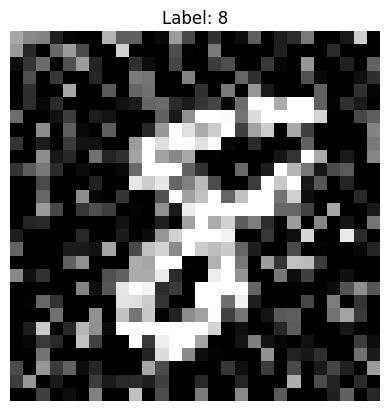

In [210]:
image, label = train_data_noisy[0]

image_np = image.squeeze(0).numpy()
label = label.item()

# Plot the image
plt.imshow(image_np, cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

In [211]:
model_best_noisy = CNN(
  kernel_size=best_run.config['kernel_size'],
  stride=best_run.config['stride'],
  padding=best_run.config['padding'],
  dropout=best_run.config['dropout'],
  learning_rate=best_run.config['learning_rate'],
  batch_size=best_run.config['batch_size'],
  num_epochs=best_run.config['num_epochs']
)

model_best_noisy.train_model(train_data_noisy, val_data_noisy)

Epoch 1/10, Loss(Train): 1314.5523, Accuracy(Train): 0.79, Loss(Val): 239.1022, Accuracy(Val): 0.94
Epoch 2/10, Loss(Train): 1177.1307, Accuracy(Train): 0.96, Loss(Val): 235.2839, Accuracy(Val): 0.96
Epoch 3/10, Loss(Train): 1168.7634, Accuracy(Train): 0.97, Loss(Val): 234.2052, Accuracy(Val): 0.97
Epoch 4/10, Loss(Train): 1164.5324, Accuracy(Train): 0.97, Loss(Val): 233.4145, Accuracy(Val): 0.98
Epoch 5/10, Loss(Train): 1161.9079, Accuracy(Train): 0.98, Loss(Val): 233.1745, Accuracy(Val): 0.98
Epoch 6/10, Loss(Train): 1159.1702, Accuracy(Train): 0.98, Loss(Val): 232.5825, Accuracy(Val): 0.98
Epoch 7/10, Loss(Train): 1157.5088, Accuracy(Train): 0.98, Loss(Val): 232.4969, Accuracy(Val): 0.98
Epoch 8/10, Loss(Train): 1156.5363, Accuracy(Train): 0.98, Loss(Val): 232.2729, Accuracy(Val): 0.98
Epoch 9/10, Loss(Train): 1155.1538, Accuracy(Train): 0.98, Loss(Val): 232.0908, Accuracy(Val): 0.98
Epoch 10/10, Loss(Train): 1154.1846, Accuracy(Train): 0.99, Loss(Val): 231.7886, Accuracy(Val): 0.99

(1154.1846497058868, 231.78863739967346, 0.98582, 0.9851)

### Task 4.6 Autoencoder

In [212]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(1, 16, 3, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(16, 32, 3, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(32, 64, 7),
    )
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(64, 32, 7),
      nn.ReLU(),
      nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
      nn.ReLU(),
      nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
      nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)

    return decoded

#### Training the autoencoder

In [213]:
ae = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=0.001)

num_epochs = 5
batch_size = 64

data_loader = DataLoader(train_data_noisy, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
  for data in data_loader:
    img, _ = data
    # ===================forward=====================
    output = ae(img)
    loss = criterion(output, img)
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # ===================log========================
  print(f'epoch [{epoch+1}/{num_epochs}], loss:{loss.item():.4f}')

epoch [1/5], loss:0.0447
epoch [2/5], loss:0.0435
epoch [3/5], loss:0.0423
epoch [4/5], loss:0.0410
epoch [5/5], loss:0.0416


In [214]:
denoise_train_data = []
denoise_val_data = []
denoise_test_data = []

data_loader = DataLoader(train_data_noisy, batch_size=batch_size, shuffle=False)
for data in data_loader:
  img, _ = data
  for i in range(len(img)):
    denoise_train_data.append((ae(img[i].unsqueeze(0)).squeeze(0), _[i]))

data_loader = DataLoader(val_data_noisy, batch_size=batch_size, shuffle=False)
for data in data_loader:
  img, _ = data
  for i in range(len(img)):
    denoise_val_data.append((ae(img[i].unsqueeze(0)).squeeze(0), _[i]))
  
data_loader = DataLoader(test_data_noisy, batch_size=batch_size, shuffle=False)
for data in data_loader:
  img, _ = data
  for i in range(len(img)):
    denoise_test_data.append((ae(img[i].unsqueeze(0)).squeeze(0), _[i]))


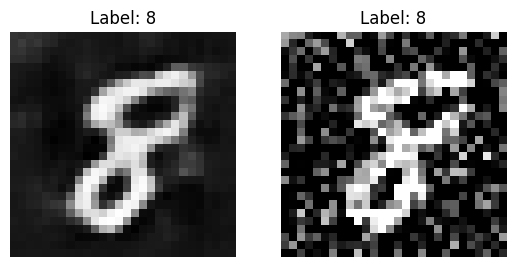

In [215]:
image, label = denoise_train_data[0]
image_np = image.squeeze(0).detach().numpy()

# Plot the image in subplot
plt.subplot(1, 2, 1)
plt.imshow(image_np, cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')

image, label = train_data_noisy[0]
image_np = image.squeeze(0).detach().numpy()

# Plot the image in subplot
plt.subplot(1, 2, 2)
plt.imshow(image_np, cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

In [216]:
ae_model = CNN(
  learning_rate=best_run.config['learning_rate'],
  batch_size=best_run.config['batch_size'],
  num_epochs=best_run.config['num_epochs'],
  stride=best_run.config['stride'],
  padding=best_run.config['padding'],
  dropout=best_run.config['dropout'],
  kernel_size=best_run.config['kernel_size'],
)

In [217]:
ae_model.train_model(denoise_train_data, denoise_val_data)

Epoch 1/10, Loss(Train): 1258.7386, Accuracy(Train): 0.86, Loss(Val): 237.0148, Accuracy(Val): 0.95
Epoch 2/10, Loss(Train): 1174.4229, Accuracy(Train): 0.96, Loss(Val): 234.8483, Accuracy(Val): 0.97
Epoch 3/10, Loss(Train): 1167.8492, Accuracy(Train): 0.97, Loss(Val): 233.7561, Accuracy(Val): 0.97
Epoch 4/10, Loss(Train): 1164.3973, Accuracy(Train): 0.97, Loss(Val): 233.4858, Accuracy(Val): 0.98
Epoch 5/10, Loss(Train): 1161.3566, Accuracy(Train): 0.98, Loss(Val): 233.1588, Accuracy(Val): 0.98
Epoch 6/10, Loss(Train): 1159.4504, Accuracy(Train): 0.98, Loss(Val): 232.8557, Accuracy(Val): 0.98
Epoch 7/10, Loss(Train): 1157.9690, Accuracy(Train): 0.98, Loss(Val): 232.5331, Accuracy(Val): 0.98
Epoch 8/10, Loss(Train): 1156.8490, Accuracy(Train): 0.98, Loss(Val): 232.1651, Accuracy(Val): 0.98
Epoch 9/10, Loss(Train): 1155.9644, Accuracy(Train): 0.98, Loss(Val): 231.9025, Accuracy(Val): 0.98
Epoch 10/10, Loss(Train): 1155.3276, Accuracy(Train): 0.98, Loss(Val): 231.8000, Accuracy(Val): 0.99

(1155.3276261091232, 231.79996871948242, 0.98406, 0.9852)

In [218]:
y_pred_denoise, y_true_denoise = ae_model.predict(denoise_test_data)

In [219]:
conf_mat_denoise = pd.DataFrame(confusion_matrix(y_true_denoise, y_pred_denoise))
conf_mat_denoise.head(10)

,0,1,2,3,4,5,6,7,8,9
0,973,0,0,0,0,1,2,1,3,0
1,0,1123,1,2,0,0,2,5,2,0
2,2,2,999,9,1,0,0,15,4,0
3,0,0,0,1003,0,1,0,2,3,1
4,0,0,1,0,967,0,2,2,2,8
5,1,0,1,13,0,862,2,2,5,6
6,4,2,3,0,1,4,942,0,2,0
7,0,2,4,1,0,0,0,1019,1,1
8,4,0,2,7,0,1,3,7,945,5
9,2,1,1,3,8,1,1,16,0,976


In [220]:
class_rep_denoise = pd.DataFrame(classification_report(y_true_denoise, y_pred_denoise, output_dict=True)).transpose()
class_rep_denoise.head(13)

,precision,recall,f1-score,support
0,0.986815,0.992857,0.989827,980.0000
1,0.993805,0.989427,0.991611,1135.0000
2,0.987154,0.968023,0.977495,1032.0000
3,0.966281,0.993069,0.979492,1010.0000
4,0.989765,0.984725,0.987238,982.0000
5,0.990805,0.966368,0.978434,892.0000
6,0.987421,0.983299,0.985356,958.0000
7,0.953227,0.991245,0.971865,1028.0000
8,0.977249,0.970226,0.973725,974.0000
9,0.978937,0.967294,0.973081,1009.0000


#### Analysis of the results

In [224]:
incorrect_predictions = []

for i in range(len(y_pred_denoise)):
  if y_pred_denoise[i] != y_true_denoise[i]:
    incorrect_predictions.append((test_data_noisy[i], denoise_test_data[i], y_pred_denoise[i], y_true_denoise[i]))

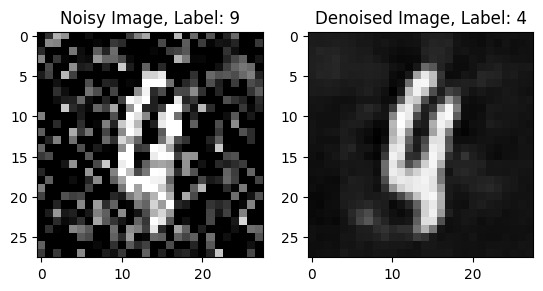

Predicted Label: 4
True Label: 9


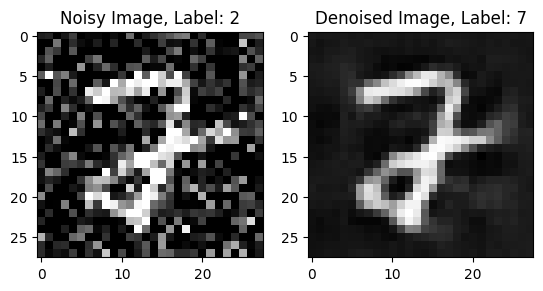

Predicted Label: 7
True Label: 2


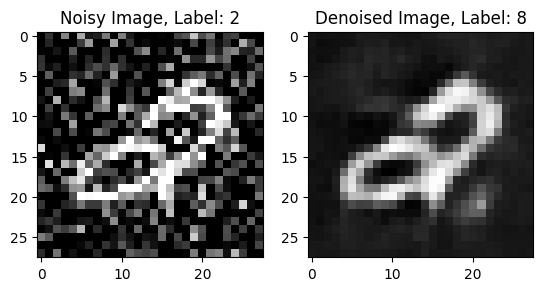

Predicted Label: 8
True Label: 2


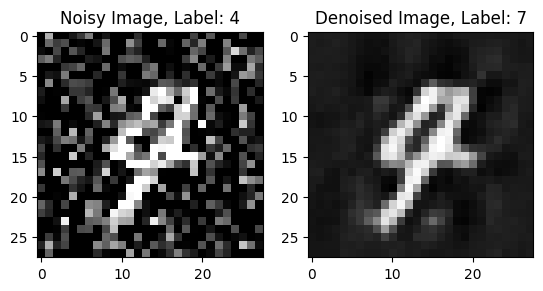

Predicted Label: 7
True Label: 4


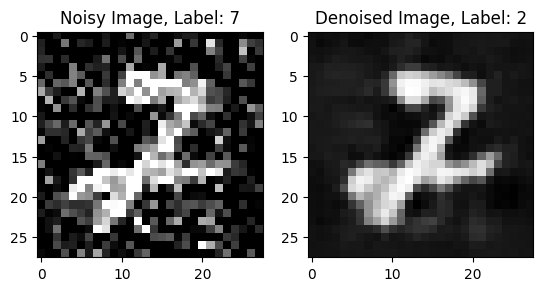

Predicted Label: 2
True Label: 7


In [225]:
for i in range(5):
  image = incorrect_predictions[i][0][0]
  image_np = image.squeeze(0).detach().numpy()
  label = incorrect_predictions[i][3]

  plt.subplot(1, 2, 1)
  plt.imshow(image_np, cmap='gray')
  plt.title(f'Noisy Image, Label: {label}')
  
  image = incorrect_predictions[i][1][0]
  image_np = image.squeeze(0).detach().numpy()
  label = incorrect_predictions[i][2]
  
  plt.subplot(1, 2, 2)
  plt.imshow(image_np, cmap='gray')
  plt.title(f'Denoised Image, Label: {label}')
  
  plt.show()

  print(f'Predicted Label: {incorrect_predictions[i][2]}')
  print(f'True Label: {incorrect_predictions[i][3]}')

#### Class imbalannce check

In [227]:
denoise_labels = []
for i in range(len(denoise_test_data)):
  denoise_labels.append(denoise_test_data[i][1])

class_counts = np.bincount(denoise_labels)
class_imbalance = class_counts / len(denoise_labels)
print("Class Imbalance:")
for i, count in enumerate(class_counts):
  print(f"Class {i}: {class_imbalance[i]*100:.2f}%")

Class Imbalance:
Class 0: 9.80%
Class 1: 11.35%
Class 2: 10.32%
Class 3: 10.10%
Class 4: 9.82%
Class 5: 8.92%
Class 6: 9.58%
Class 7: 10.28%
Class 8: 9.74%
Class 9: 10.09%


### Reasons for incorrect predictions
- The incorrect is predictions is due to the ambiguity in the samples, like I have shown some samples in the above section. The samples are not clear and it is difficult to classify them. The model is not able to learn the features properly and hence it is not able to classify the samples properly.
- Moreover, due to the class imbalance the model tends to predict the majority class more often than the minority class. This is also a reason for the incorrect predictions.